In [1]:
import numpy as np
import h5py
import pandas as p
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

np.random.seed(0)

In [2]:
h5_spec = h5py.File('lc_mag_g.h5', 'r')
#print([attr for attr in h5_spec['header'].attrs]) 

In [3]:
for key in h5_spec.keys():
    print(key)

header
lc_mags
params


In [4]:
#process time array
observation_times_str = h5_spec['header'].attrs['observation_times']

number_strings = observation_times_str.strip('[]').replace('\n', ' ').split()

observation_times = [float(num_str) for num_str in number_strings]

times = np.array(observation_times)

times.shape 

(73,)

In [5]:
#process mags array
mags = h5_spec['lc_mags']
print(mags)
mags_array = np.array(mags)
mags_array.shape

<HDF5 dataset "lc_mags": shape (540, 73), type "<f8">


(540, 73)

In [6]:
#process params array
params = h5_spec['params']
print(params)
params_array = np.array(params)
params_array.shape

<HDF5 dataset "params": shape (540, 3), type "<f8">


(540, 3)

In [8]:
avg = np.mean(mags_array, axis=0)
std = np.std(mags_array, axis=0)

whitened_mags_array = (mags_array - avg) / std

In [9]:
#mean.shape
#whitened_mags_array.shape

In [10]:
X = params_array
y = whitened_mags_array

# #Log mass and linear velocity
# X[:, 0] = np.log10(X[:, 0])
# X[:, 1] = np.power(10, X[: ,1])
# X[:, 2] = np.log10(X[:, 2])
# X[:, 3] = np.power(10, X[:, 3])

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)

In [11]:
%%time
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
        )
        self.mean = nn.Linear(256, 64)
        self.logvar = nn.Linear(256, 64)

    def forward(self, x):
        x = self.model(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 73),
        )

    def forward(self, x):
        return self.model(x)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

#Hyperparameters
epochs = 10000
batch_size = 32
initial_learning_rate = 0.002
decay_steps = 10
decay_rate = 0.95

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=initial_learning_rate)
lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

#Training
def vae_loss(recon_y, true_y, mean, logvar):
    mse_loss = nn.MSELoss(reduction='mean')(recon_y, true_y)
    #kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) #include kl_divergence term if you want to use VAE
    return mse_loss # + kl_div

train_mse_loss_list = []
val_mse_loss_list = []

for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        recon_y, mean, logvar = vae(x.float())
        loss = vae_loss(recon_y, y.float(), mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    lr_schedule.step()
    
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_dataloader:
            recon_y, mean, logvar = vae(x.float())
            loss = vae_loss(recon_y, y.float(), mean, logvar)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    train_loss /= len(train_dataloader)
    
    train_mse_loss_list.append(train_loss)
    val_mse_loss_list.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Learning Rate: {optimizer.param_groups[0]['lr']}")

vae.eval()

Epoch 1/10000, Train Loss: 0.8665699706627772, Val Loss: 0.4508139193058014, Learning Rate: 0.002
Epoch 2/10000, Train Loss: 0.5361829766860375, Val Loss: 0.30645283684134483, Learning Rate: 0.002
Epoch 3/10000, Train Loss: 0.4831874599823585, Val Loss: 0.32870978862047195, Learning Rate: 0.002
Epoch 4/10000, Train Loss: 0.5039621454018813, Val Loss: 0.30149879679083824, Learning Rate: 0.002
Epoch 5/10000, Train Loss: 0.47033867010703456, Val Loss: 0.30128565803170204, Learning Rate: 0.002
Epoch 6/10000, Train Loss: 0.4593949604492921, Val Loss: 0.47081270068883896, Learning Rate: 0.002
Epoch 7/10000, Train Loss: 0.44944662084946263, Val Loss: 0.34763114154338837, Learning Rate: 0.002
Epoch 8/10000, Train Loss: 0.47265644715382504, Val Loss: 0.2755750957876444, Learning Rate: 0.002
Epoch 9/10000, Train Loss: 0.48684664414479184, Val Loss: 0.3744514212012291, Learning Rate: 0.002
Epoch 10/10000, Train Loss: 0.44641601466215575, Val Loss: 0.27634915709495544, Learning Rate: 0.0019
Epoch 

Epoch 77/10000, Train Loss: 0.25254237021391207, Val Loss: 0.14756252709776163, Learning Rate: 0.0013966745921874994
Epoch 78/10000, Train Loss: 0.1753456056691133, Val Loss: 0.16063851304352283, Learning Rate: 0.0013966745921874994
Epoch 79/10000, Train Loss: 0.18156677656448805, Val Loss: 0.32264428958296776, Learning Rate: 0.0013966745921874994
Epoch 80/10000, Train Loss: 0.17879158430374587, Val Loss: 0.1379946330562234, Learning Rate: 0.0013268408625781243
Epoch 81/10000, Train Loss: 0.17013341131118628, Val Loss: 0.2163658570498228, Learning Rate: 0.0013268408625781243
Epoch 82/10000, Train Loss: 0.1585408294430146, Val Loss: 0.18513482622802258, Learning Rate: 0.0013268408625781243
Epoch 83/10000, Train Loss: 0.1561474229853887, Val Loss: 0.18219199776649475, Learning Rate: 0.0013268408625781243
Epoch 84/10000, Train Loss: 0.15374204974908096, Val Loss: 0.12536566494964063, Learning Rate: 0.0013268408625781243
Epoch 85/10000, Train Loss: 0.17035625932308343, Val Loss: 0.14153250

Epoch 149/10000, Train Loss: 0.13958990975068167, Val Loss: 0.12449543457478285, Learning Rate: 0.0009753499582310589
Epoch 150/10000, Train Loss: 0.13784253425323045, Val Loss: 0.11647206405177712, Learning Rate: 0.0009265824603195059
Epoch 151/10000, Train Loss: 0.14216447850832573, Val Loss: 0.12578512262552977, Learning Rate: 0.0009265824603195059
Epoch 152/10000, Train Loss: 0.14220377344351548, Val Loss: 0.12954498454928398, Learning Rate: 0.0009265824603195059
Epoch 153/10000, Train Loss: 0.13404049083160666, Val Loss: 0.13753577694296837, Learning Rate: 0.0009265824603195059
Epoch 154/10000, Train Loss: 0.14902185992552683, Val Loss: 0.11313939047977328, Learning Rate: 0.0009265824603195059
Epoch 155/10000, Train Loss: 0.1493887405555982, Val Loss: 0.11411425052210689, Learning Rate: 0.0009265824603195059
Epoch 156/10000, Train Loss: 0.13765385173834288, Val Loss: 0.11977962218225002, Learning Rate: 0.0009265824603195059
Epoch 157/10000, Train Loss: 0.15031387714239267, Val Los

Epoch 221/10000, Train Loss: 0.06871730275452137, Val Loss: 0.12593377940356731, Learning Rate: 0.0006470670899474179
Epoch 222/10000, Train Loss: 0.08649508311198308, Val Loss: 0.0975170936435461, Learning Rate: 0.0006470670899474179
Epoch 223/10000, Train Loss: 0.08289473546812168, Val Loss: 0.11702803708612919, Learning Rate: 0.0006470670899474179
Epoch 224/10000, Train Loss: 0.0622866667377261, Val Loss: 0.07003772631287575, Learning Rate: 0.0006470670899474179
Epoch 225/10000, Train Loss: 0.05466894963039802, Val Loss: 0.024664667376782745, Learning Rate: 0.0006470670899474179
Epoch 226/10000, Train Loss: 0.03314831781272705, Val Loss: 0.03131974348798394, Learning Rate: 0.0006470670899474179
Epoch 227/10000, Train Loss: 0.03975028028854957, Val Loss: 0.09954551607370377, Learning Rate: 0.0006470670899474179
Epoch 228/10000, Train Loss: 0.04153084052869907, Val Loss: 0.05945472605526447, Learning Rate: 0.0006470670899474179
Epoch 229/10000, Train Loss: 0.04883046054209654, Val Los

Epoch 293/10000, Train Loss: 0.03809032037567634, Val Loss: 0.05191244790330529, Learning Rate: 0.0004518710819851309
Epoch 294/10000, Train Loss: 0.03903979607499563, Val Loss: 0.051605737302452326, Learning Rate: 0.0004518710819851309
Epoch 295/10000, Train Loss: 0.03019110421435191, Val Loss: 0.020072026643902063, Learning Rate: 0.0004518710819851309
Epoch 296/10000, Train Loss: 0.02791423859217992, Val Loss: 0.02982242510188371, Learning Rate: 0.0004518710819851309
Epoch 297/10000, Train Loss: 0.03056986930851753, Val Loss: 0.027634613681584597, Learning Rate: 0.0004518710819851309
Epoch 298/10000, Train Loss: 0.03619678970426321, Val Loss: 0.06616609962657094, Learning Rate: 0.0004518710819851309
Epoch 299/10000, Train Loss: 0.09103935684722203, Val Loss: 0.02500504642375745, Learning Rate: 0.0004518710819851309
Epoch 300/10000, Train Loss: 0.047040100854176745, Val Loss: 0.05185993737541139, Learning Rate: 0.0004292775278858743
Epoch 301/10000, Train Loss: 0.044974384256280385, V

Epoch 362/10000, Train Loss: 0.01354978288201472, Val Loss: 0.014996421290561557, Learning Rate: 0.0003155584295764534
Epoch 363/10000, Train Loss: 0.014388860991367927, Val Loss: 0.010840912524145097, Learning Rate: 0.0003155584295764534
Epoch 364/10000, Train Loss: 0.017761881499049757, Val Loss: 0.01269137067720294, Learning Rate: 0.0003155584295764534
Epoch 365/10000, Train Loss: 0.018947802770596284, Val Loss: 0.028729379235301167, Learning Rate: 0.0003155584295764534
Epoch 366/10000, Train Loss: 0.016129614731583457, Val Loss: 0.015685665770433843, Learning Rate: 0.0003155584295764534
Epoch 367/10000, Train Loss: 0.014715959819463583, Val Loss: 0.012012241291813552, Learning Rate: 0.0003155584295764534
Epoch 368/10000, Train Loss: 0.015539129694493918, Val Loss: 0.027561789844185114, Learning Rate: 0.0003155584295764534
Epoch 369/10000, Train Loss: 0.019554798491299152, Val Loss: 0.011378055962268263, Learning Rate: 0.0003155584295764534
Epoch 370/10000, Train Loss: 0.01569197814

Epoch 431/10000, Train Loss: 0.013812795030669523, Val Loss: 0.011982605545199476, Learning Rate: 0.00022036622047001038
Epoch 432/10000, Train Loss: 0.022971097881404254, Val Loss: 0.015123551245778799, Learning Rate: 0.00022036622047001038
Epoch 433/10000, Train Loss: 0.012581122716745505, Val Loss: 0.012929502408951521, Learning Rate: 0.00022036622047001038
Epoch 434/10000, Train Loss: 0.011240668666477386, Val Loss: 0.01209271198604256, Learning Rate: 0.00022036622047001038
Epoch 435/10000, Train Loss: 0.01722010370129003, Val Loss: 0.019087577020400204, Learning Rate: 0.00022036622047001038
Epoch 436/10000, Train Loss: 0.014656839605707388, Val Loss: 0.02027130755595863, Learning Rate: 0.00022036622047001038
Epoch 437/10000, Train Loss: 0.012865385649582515, Val Loss: 0.010270915168803185, Learning Rate: 0.00022036622047001038
Epoch 438/10000, Train Loss: 0.011912756492025577, Val Loss: 0.011335219453030732, Learning Rate: 0.00022036622047001038
Epoch 439/10000, Train Loss: 0.0119

Epoch 500/10000, Train Loss: 0.016560630165398695, Val Loss: 0.042276473715901375, Learning Rate: 0.0001538899505534262
Epoch 501/10000, Train Loss: 0.02068011355228149, Val Loss: 0.04029098409228027, Learning Rate: 0.0001538899505534262
Epoch 502/10000, Train Loss: 0.015194612734306317, Val Loss: 0.010081610787892714, Learning Rate: 0.0001538899505534262
Epoch 503/10000, Train Loss: 0.010717471076462131, Val Loss: 0.02327986224554479, Learning Rate: 0.0001538899505534262
Epoch 504/10000, Train Loss: 0.00994363921479537, Val Loss: 0.01027828868245706, Learning Rate: 0.0001538899505534262
Epoch 505/10000, Train Loss: 0.010598360444419086, Val Loss: 0.009991398925194517, Learning Rate: 0.0001538899505534262
Epoch 506/10000, Train Loss: 0.009985337499529123, Val Loss: 0.019101726356893778, Learning Rate: 0.0001538899505534262
Epoch 507/10000, Train Loss: 0.011343018115999607, Val Loss: 0.009936223024851643, Learning Rate: 0.0001538899505534262
Epoch 508/10000, Train Loss: 0.00999992403488

Epoch 569/10000, Train Loss: 0.009864015621133149, Val Loss: 0.011213252855668543, Learning Rate: 0.0001131232547005058
Epoch 570/10000, Train Loss: 0.010941795476425726, Val Loss: 0.012512627086834982, Learning Rate: 0.0001074670919654805
Epoch 571/10000, Train Loss: 0.011544041980344515, Val Loss: 0.03563954448327422, Learning Rate: 0.0001074670919654805
Epoch 572/10000, Train Loss: 0.011716976954350965, Val Loss: 0.015554076351691037, Learning Rate: 0.0001074670919654805
Epoch 573/10000, Train Loss: 0.01757733219374831, Val Loss: 0.014498606557026505, Learning Rate: 0.0001074670919654805
Epoch 574/10000, Train Loss: 0.02088985971819896, Val Loss: 0.013858941951184534, Learning Rate: 0.0001074670919654805
Epoch 575/10000, Train Loss: 0.04355111721759805, Val Loss: 0.01325568393804133, Learning Rate: 0.0001074670919654805
Epoch 576/10000, Train Loss: 0.02057050572385868, Val Loss: 0.016497239470481873, Learning Rate: 0.0001074670919654805
Epoch 577/10000, Train Loss: 0.013501428891546

Epoch 638/10000, Train Loss: 0.011335120258781198, Val Loss: 0.010038898020866327, Learning Rate: 7.899818781287577e-05
Epoch 639/10000, Train Loss: 0.009410602721170737, Val Loss: 0.014574971282854676, Learning Rate: 7.899818781287577e-05
Epoch 640/10000, Train Loss: 0.010953669919847297, Val Loss: 0.013222283101640642, Learning Rate: 7.504827842223198e-05
Epoch 641/10000, Train Loss: 0.012470868937760735, Val Loss: 0.010353805831982754, Learning Rate: 7.504827842223198e-05
Epoch 642/10000, Train Loss: 0.009216935194742221, Val Loss: 0.015363240148872137, Learning Rate: 7.504827842223198e-05
Epoch 643/10000, Train Loss: 0.011147253304863205, Val Loss: 0.012019265908747911, Learning Rate: 7.504827842223198e-05
Epoch 644/10000, Train Loss: 0.011955938910922179, Val Loss: 0.018258064752444625, Learning Rate: 7.504827842223198e-05
Epoch 645/10000, Train Loss: 0.014126042351843072, Val Loss: 0.01561395195312798, Learning Rate: 7.504827842223198e-05
Epoch 646/10000, Train Loss: 0.0099556183

Epoch 707/10000, Train Loss: 0.011640595379643716, Val Loss: 0.01087792104226537, Learning Rate: 5.516738087354988e-05
Epoch 708/10000, Train Loss: 0.01170238211321143, Val Loss: 0.026151930214837193, Learning Rate: 5.516738087354988e-05
Epoch 709/10000, Train Loss: 0.009176373625030885, Val Loss: 0.013099486008286476, Learning Rate: 5.516738087354988e-05
Epoch 710/10000, Train Loss: 0.008950633292372983, Val Loss: 0.011883652652613819, Learning Rate: 5.240901182987238e-05
Epoch 711/10000, Train Loss: 0.01101328688673675, Val Loss: 0.010621768204146065, Learning Rate: 5.240901182987238e-05
Epoch 712/10000, Train Loss: 0.013032113273556415, Val Loss: 0.010403993976069614, Learning Rate: 5.240901182987238e-05
Epoch 713/10000, Train Loss: 0.012986007898759384, Val Loss: 0.01059038209496066, Learning Rate: 5.240901182987238e-05
Epoch 714/10000, Train Loss: 0.01276054851209315, Val Loss: 0.013886053464375436, Learning Rate: 5.240901182987238e-05
Epoch 715/10000, Train Loss: 0.01014530083249

Epoch 776/10000, Train Loss: 0.010970735071728436, Val Loss: 0.023821274982765317, Learning Rate: 3.8525439591808865e-05
Epoch 777/10000, Train Loss: 0.011933085768340299, Val Loss: 0.017613002681173384, Learning Rate: 3.8525439591808865e-05
Epoch 778/10000, Train Loss: 0.01048127429273266, Val Loss: 0.024180617416277528, Learning Rate: 3.8525439591808865e-05
Epoch 779/10000, Train Loss: 0.009040175686375452, Val Loss: 0.01388394518289715, Learning Rate: 3.8525439591808865e-05
Epoch 780/10000, Train Loss: 0.012819262651296763, Val Loss: 0.010518422088352963, Learning Rate: 3.659916761221842e-05
Epoch 781/10000, Train Loss: 0.011943336450853027, Val Loss: 0.01303194131469354, Learning Rate: 3.659916761221842e-05
Epoch 782/10000, Train Loss: 0.010854616922398027, Val Loss: 0.011692382671753876, Learning Rate: 3.659916761221842e-05
Epoch 783/10000, Train Loss: 0.009148947858753113, Val Loss: 0.010582675051409751, Learning Rate: 3.659916761221842e-05
Epoch 784/10000, Train Loss: 0.00906165

Epoch 845/10000, Train Loss: 0.010131878276857046, Val Loss: 0.022342463955283165, Learning Rate: 2.6903751315366905e-05
Epoch 846/10000, Train Loss: 0.008557023973060915, Val Loss: 0.01857739849947393, Learning Rate: 2.6903751315366905e-05
Epoch 847/10000, Train Loss: 0.008943835667406138, Val Loss: 0.014792401576414704, Learning Rate: 2.6903751315366905e-05
Epoch 848/10000, Train Loss: 0.009218900034633966, Val Loss: 0.010276689528836869, Learning Rate: 2.6903751315366905e-05
Epoch 849/10000, Train Loss: 0.008984445522610959, Val Loss: 0.024741467321291566, Learning Rate: 2.6903751315366905e-05
Epoch 850/10000, Train Loss: 0.009906594032564988, Val Loss: 0.010635411570547149, Learning Rate: 2.555856374959856e-05
Epoch 851/10000, Train Loss: 0.008924779374725543, Val Loss: 0.010441580903716385, Learning Rate: 2.555856374959856e-05
Epoch 852/10000, Train Loss: 0.009286425806259593, Val Loss: 0.01067979764775373, Learning Rate: 2.555856374959856e-05
Epoch 853/10000, Train Loss: 0.009242

Epoch 914/10000, Train Loss: 0.008923276578291105, Val Loss: 0.01086033004685305, Learning Rate: 1.8787892948351987e-05
Epoch 915/10000, Train Loss: 0.009517975151538849, Val Loss: 0.012665098300203681, Learning Rate: 1.8787892948351987e-05
Epoch 916/10000, Train Loss: 0.00883388902562169, Val Loss: 0.016374435974285007, Learning Rate: 1.8787892948351987e-05
Epoch 917/10000, Train Loss: 0.008293618662999226, Val Loss: 0.014557966031134129, Learning Rate: 1.8787892948351987e-05
Epoch 918/10000, Train Loss: 0.008370231648978706, Val Loss: 0.01031128756585531, Learning Rate: 1.8787892948351987e-05
Epoch 919/10000, Train Loss: 0.008537802558678847, Val Loss: 0.01119285574532114, Learning Rate: 1.8787892948351987e-05
Epoch 920/10000, Train Loss: 0.00912198604335292, Val Loss: 0.015528361778706312, Learning Rate: 1.784849830093439e-05
Epoch 921/10000, Train Loss: 0.010202583104658585, Val Loss: 0.010356900573242456, Learning Rate: 1.784849830093439e-05
Epoch 922/10000, Train Loss: 0.00872011

Epoch 983/10000, Train Loss: 0.009090835747953791, Val Loss: 0.011977165821008384, Learning Rate: 1.3120286360850959e-05
Epoch 984/10000, Train Loss: 0.009643793392639894, Val Loss: 0.010554367356235161, Learning Rate: 1.3120286360850959e-05
Epoch 985/10000, Train Loss: 0.008773606216821533, Val Loss: 0.013738979469053447, Learning Rate: 1.3120286360850959e-05
Epoch 986/10000, Train Loss: 0.00843607395206793, Val Loss: 0.010641711742209736, Learning Rate: 1.3120286360850959e-05
Epoch 987/10000, Train Loss: 0.009087172372696491, Val Loss: 0.010369187191827223, Learning Rate: 1.3120286360850959e-05
Epoch 988/10000, Train Loss: 0.009705170200994382, Val Loss: 0.010917562365648337, Learning Rate: 1.3120286360850959e-05
Epoch 989/10000, Train Loss: 0.00872694280741808, Val Loss: 0.014863508753478527, Learning Rate: 1.3120286360850959e-05
Epoch 990/10000, Train Loss: 0.008425145060755312, Val Loss: 0.010631636643665843, Learning Rate: 1.246427204280841e-05
Epoch 991/10000, Train Loss: 0.0085

Epoch 1052/10000, Train Loss: 0.00964739857814633, Val Loss: 0.02938757376978174, Learning Rate: 9.162385301212364e-06
Epoch 1053/10000, Train Loss: 0.008241375979895774, Val Loss: 0.012012130464427173, Learning Rate: 9.162385301212364e-06
Epoch 1054/10000, Train Loss: 0.008430253535222549, Val Loss: 0.010254038395942189, Learning Rate: 9.162385301212364e-06
Epoch 1055/10000, Train Loss: 0.008201356847376492, Val Loss: 0.01568178436718881, Learning Rate: 9.162385301212364e-06
Epoch 1056/10000, Train Loss: 0.009411929443908425, Val Loss: 0.01053893446805887, Learning Rate: 9.162385301212364e-06
Epoch 1057/10000, Train Loss: 0.008495530077757744, Val Loss: 0.011164992116391659, Learning Rate: 9.162385301212364e-06
Epoch 1058/10000, Train Loss: 0.008290156569833366, Val Loss: 0.01031623434391804, Learning Rate: 9.162385301212364e-06
Epoch 1059/10000, Train Loss: 0.008401273165453369, Val Loss: 0.010657492937752977, Learning Rate: 9.162385301212364e-06
Epoch 1060/10000, Train Loss: 0.01048

Epoch 1121/10000, Train Loss: 0.00833540591590393, Val Loss: 0.010315064864698797, Learning Rate: 6.398435377017759e-06
Epoch 1122/10000, Train Loss: 0.00816974707861216, Val Loss: 0.019068713765591383, Learning Rate: 6.398435377017759e-06
Epoch 1123/10000, Train Loss: 0.008787990153695528, Val Loss: 0.010424770254758187, Learning Rate: 6.398435377017759e-06
Epoch 1124/10000, Train Loss: 0.008408388785588054, Val Loss: 0.010331416066037491, Learning Rate: 6.398435377017759e-06
Epoch 1125/10000, Train Loss: 0.008188508032337548, Val Loss: 0.018606351921334863, Learning Rate: 6.398435377017759e-06
Epoch 1126/10000, Train Loss: 0.009960702387616038, Val Loss: 0.010363359295297414, Learning Rate: 6.398435377017759e-06
Epoch 1127/10000, Train Loss: 0.008376506264679708, Val Loss: 0.020035518798977137, Learning Rate: 6.398435377017759e-06
Epoch 1128/10000, Train Loss: 0.009853414080750484, Val Loss: 0.010334196267649531, Learning Rate: 6.398435377017759e-06
Epoch 1129/10000, Train Loss: 0.00

Epoch 1190/10000, Train Loss: 0.009624869795516133, Val Loss: 0.010240830986731453, Learning Rate: 4.468266060417174e-06
Epoch 1191/10000, Train Loss: 0.009759446319479208, Val Loss: 0.010459299868671224, Learning Rate: 4.468266060417174e-06
Epoch 1192/10000, Train Loss: 0.009372566020689331, Val Loss: 0.016276679234579206, Learning Rate: 4.468266060417174e-06
Epoch 1193/10000, Train Loss: 0.008744287555320905, Val Loss: 0.0181765160523355, Learning Rate: 4.468266060417174e-06
Epoch 1194/10000, Train Loss: 0.00823334430774244, Val Loss: 0.011635148664936423, Learning Rate: 4.468266060417174e-06
Epoch 1195/10000, Train Loss: 0.008795124621918568, Val Loss: 0.01028024172410369, Learning Rate: 4.468266060417174e-06
Epoch 1196/10000, Train Loss: 0.008269018226061374, Val Loss: 0.010916919854935259, Learning Rate: 4.468266060417174e-06
Epoch 1197/10000, Train Loss: 0.00967423918728645, Val Loss: 0.010326033545425162, Learning Rate: 4.468266060417174e-06
Epoch 1198/10000, Train Loss: 0.00827

Epoch 1259/10000, Train Loss: 0.009901878423988819, Val Loss: 0.014538891962729394, Learning Rate: 3.2845861461675798e-06
Epoch 1260/10000, Train Loss: 0.008153312750017414, Val Loss: 0.010393594595370814, Learning Rate: 3.1203568388592007e-06
Epoch 1261/10000, Train Loss: 0.00832317174018289, Val Loss: 0.010365233218180947, Learning Rate: 3.1203568388592007e-06
Epoch 1262/10000, Train Loss: 0.00823012174357875, Val Loss: 0.011091716878581792, Learning Rate: 3.1203568388592007e-06
Epoch 1263/10000, Train Loss: 0.009368462577605477, Val Loss: 0.011173086881171912, Learning Rate: 3.1203568388592007e-06
Epoch 1264/10000, Train Loss: 0.008202382269351242, Val Loss: 0.0104177606626763, Learning Rate: 3.1203568388592007e-06
Epoch 1265/10000, Train Loss: 0.010945237832717024, Val Loss: 0.010256473302433733, Learning Rate: 3.1203568388592007e-06
Epoch 1266/10000, Train Loss: 0.008353772322432352, Val Loss: 0.01650611823424697, Learning Rate: 3.1203568388592007e-06
Epoch 1267/10000, Train Loss:

KeyboardInterrupt: 

In [12]:
from sklearn.metrics import mean_squared_error

with torch.no_grad():
    y_test_generated, _, _ = vae(X_test) #prediction

y_test_generated = y_test_generated.numpy()
mse_loss = mean_squared_error(y_test, y_test_generated)

print(f"Average MSE for all test points: {mse_loss:.4f}")

Average MSE for all test points: 0.0130


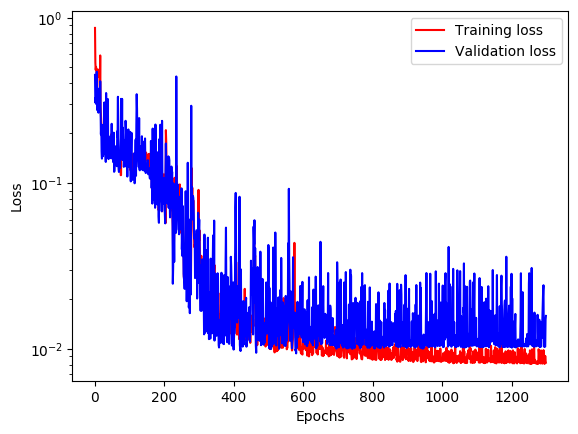

In [13]:
epochs = range(1, len(train_mse_loss_list) + 1)

plt.figure()

plt.plot(epochs, train_mse_loss_list, 'r', label='Training loss')

plt.plot(epochs, val_mse_loss_list, 'b', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

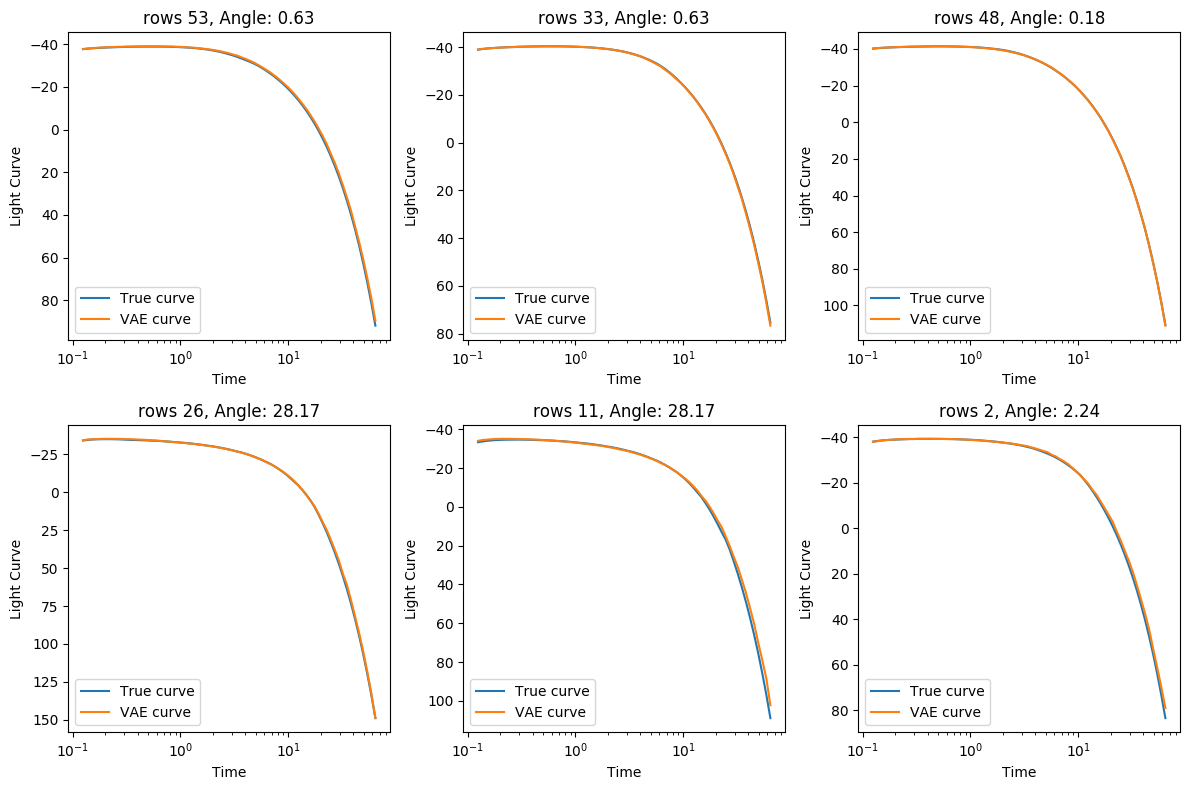

In [14]:
from matplotlib import rc

plt.rcParams.update(plt.rcParamsDefault)

fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = axes.ravel()

samples = np.random.choice(len(X_test), 6, replace=False)
X_samples = X_test[samples]

X_samples_np = X_samples.numpy()
angle_values = X_samples_np[:, -1]

for i in range(6):
    ax = axes[i]
    ax.plot(times, y_test[samples[i]]*std + avg, label="True curve")
    ax.plot(times, y_test_generated[samples[i]]*std + avg, label="VAE curve")
    angle_value = angle_values[i]
    ax.set_title(f"rows {samples[i]}, Angle: {angle_value:.2f}")
    ax.legend()
    axes[i].set_xscale('log')
    axes[i].invert_yaxis()
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Light Curve')

plt.tight_layout()
plt.show()

In [ ]:
type(y_test[samples[1]])
type(mean)